## RQ3 Full Process

General plan:
- Load the tokens for class 3 and 6 (created in RQ2)
- Assign each token their cluster from RQ2
- Isolate the clusters I'm interested in 
- Compare those clusters (word cloud, cluster membership metric?)

To do: think about how to handle the max class - should it be the max across all classes, the max across class 3, 4, 5, 6 or the max between 3 and 6

In [2]:
# SETUP

# Import packages
import pandas as pd
import pickle

import spacy
from deep_translator import GoogleTranslator
from collections import Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Load 2 sets of tokens for class 3 and 6

These were created as part of RQ2.

In [3]:
# STEP 1: LOAD CLASS TOKENS

filtered_tokens_lc_c3 = pickle.load(open("./processing/final_tokens_c3.p", "rb"))
filtered_tokens_lc_c6 = pickle.load(open("./processing/final_tokens_c6.p", "rb"))


In [4]:
# STEP 1: CHECK GENERAL RESULTS

word_freq_c3 = Counter(filtered_tokens_lc_c3)
common_words_c3 = word_freq_c3.most_common(20)

word_freq_c6 = Counter(filtered_tokens_lc_c6)
common_words_c6 = word_freq_c6.most_common(20)

common_words_c3[0:9], common_words_c6[0:9]

([('wanderung', 9),
  ('weg', 6),
  ('to', 5),
  ('entlang', 4),
  ('rauhkopf', 4),
  ('jaegerkamp', 4),
  ('linderhof', 4),
  ('m', 3),
  ('bartholomä', 3)],
 [('weg', 155),
  ('blick', 111),
  ('aussicht', 99),
  ('parkplatz', 84),
  ('burg', 82),
  ('rechts', 70),
  ('wald', 69),
  ('entlang', 68),
  ('schöne', 68)])

### Step 2: Assign clusters

Assign each token their cluster from rq2_step2_text_analysis.ipynb

In [5]:
# STEP 2: LOAD TOKEN/CLUSTER LOOKUP FROM RQ2

token_cluster_lookup = pickle.load(open("./processing/token_cluster_all.p", "rb"))

token_cluster_lookup_dict = token_cluster_lookup.set_index("token").to_dict()["cluster"]

token_cluster_lookup_dict

{'breite': 13,
 'forstwege': 11,
 'pfade': 5,
 'halber': 13,
 'strecke': 5,
 'einkehren': 10,
 'montag': 13,
 'ruhetag': 11,
 'rinken': 1,
 'schauinsland': 1,
 'arten': 6,
 'menschen': 13,
 'geeignet': 10,
 'gipfel': 9,
 'abgerundet': 10,
 'bietet': 10,
 'guten': 13,
 'blick': 13,
 'schwarzen': 13,
 'dschungel': 6,
 'nördlichen': 13,
 'hang': 9,
 'schweizer': 13,
 'berge': 9,
 'liechtenstein': 13,
 'feldberg': 1,
 'm': 9,
 'schwarzes': 13,
 'deutschland': 13,
 'linke': 13,
 'gabelung': 11,
 'feldsee': 1,
 'see': 12,
 'bank': 13,
 'top': 3,
 'monolith': 13,
 'titisee': 1,
 'camping': 12,
 'teich': 6,
 'ruhestein': 1,
 'bartholomä': 1,
 'schönen': 12,
 'fuss': 11,
 'watzmann': 9,
 'ostwand': 9,
 'gleichem': 13,
 'weg': 4,
 'entlang': 4,
 'richtung': 4,
 'norden': 13,
 'beginnt': 10,
 'wald': 6,
 'zunehmend': 13,
 'ausgesetzter': 6,
 'wanderer': 11,
 'höhenangst': 9,
 'steig': 9,
 'erreicht': 10,
 'schließlich': 13,
 'aussichtspunkt': 9,
 'schöner': 12,
 'aussicht': 9,
 'königssee': 1,
 '

In [6]:
# STEP 2: MAP TOKENS TO CLUSERS

# Create a df with tokens as one column
final_tokens_c3_df = pd.DataFrame({'token': filtered_tokens_lc_c3})
final_tokens_c6_df = pd.DataFrame({'token': filtered_tokens_lc_c6})

# Add cluster column using dictionary as lookup
final_tokens_c3_df["cluster"] = final_tokens_c3_df["token"].map(token_cluster_lookup_dict)
final_tokens_c6_df["cluster"] = final_tokens_c6_df["token"].map(token_cluster_lookup_dict)

# Remove NaN entries (these are ones that were missing from the model during vectorisation)
final_tokens_c3_df = final_tokens_c3_df.dropna()
final_tokens_c6_df = final_tokens_c6_df.dropna()

# Convert cluster number to int
final_tokens_c3_df["cluster"] = final_tokens_c3_df["cluster"].astype(int)
final_tokens_c6_df["cluster"] = final_tokens_c6_df["cluster"].astype(int)

final_tokens_c3_df

,token,cluster
0,breite,13
1,forstwege,11
2,pfade,5
3,halber,13
4,strecke,5
...,...,...
485,oktober,13
486,museum,7
487,jena,13
488,jena,13


### Step 3: Isolate clusters of interest

At the moment I'm not sure of the final clusters so the actual clusters of interest might change - the ones used now are just placeholders so I can get the process ready.


In [7]:
# STEP 3: FILTER SPECIFIC CLUSTERS

# Extract the clusters of interest
filtered_clusters_c3 = final_tokens_c3_df[(final_tokens_c3_df["cluster"]==6) | (final_tokens_c3_df["cluster"]==7) | (final_tokens_c3_df["cluster"]==9) | (final_tokens_c3_df["cluster"]==12) | (final_tokens_c3_df["cluster"]==13)]
filtered_clusters_c6 = final_tokens_c6_df[(final_tokens_c6_df["cluster"]==6) | (final_tokens_c6_df["cluster"]==7) | (final_tokens_c6_df["cluster"]==9) | (final_tokens_c6_df["cluster"]==12) | (final_tokens_c6_df["cluster"]==13)]

filtered_clusters_c3

,token,cluster
0,breite,13
3,halber,13
7,montag,13
16,arten,6
17,menschen,13
...,...,...
485,oktober,13
486,museum,7
487,jena,13
488,jena,13


### Step 4: Compare Class 3 and 6 Results

wordcloud
within cluster membership metric?

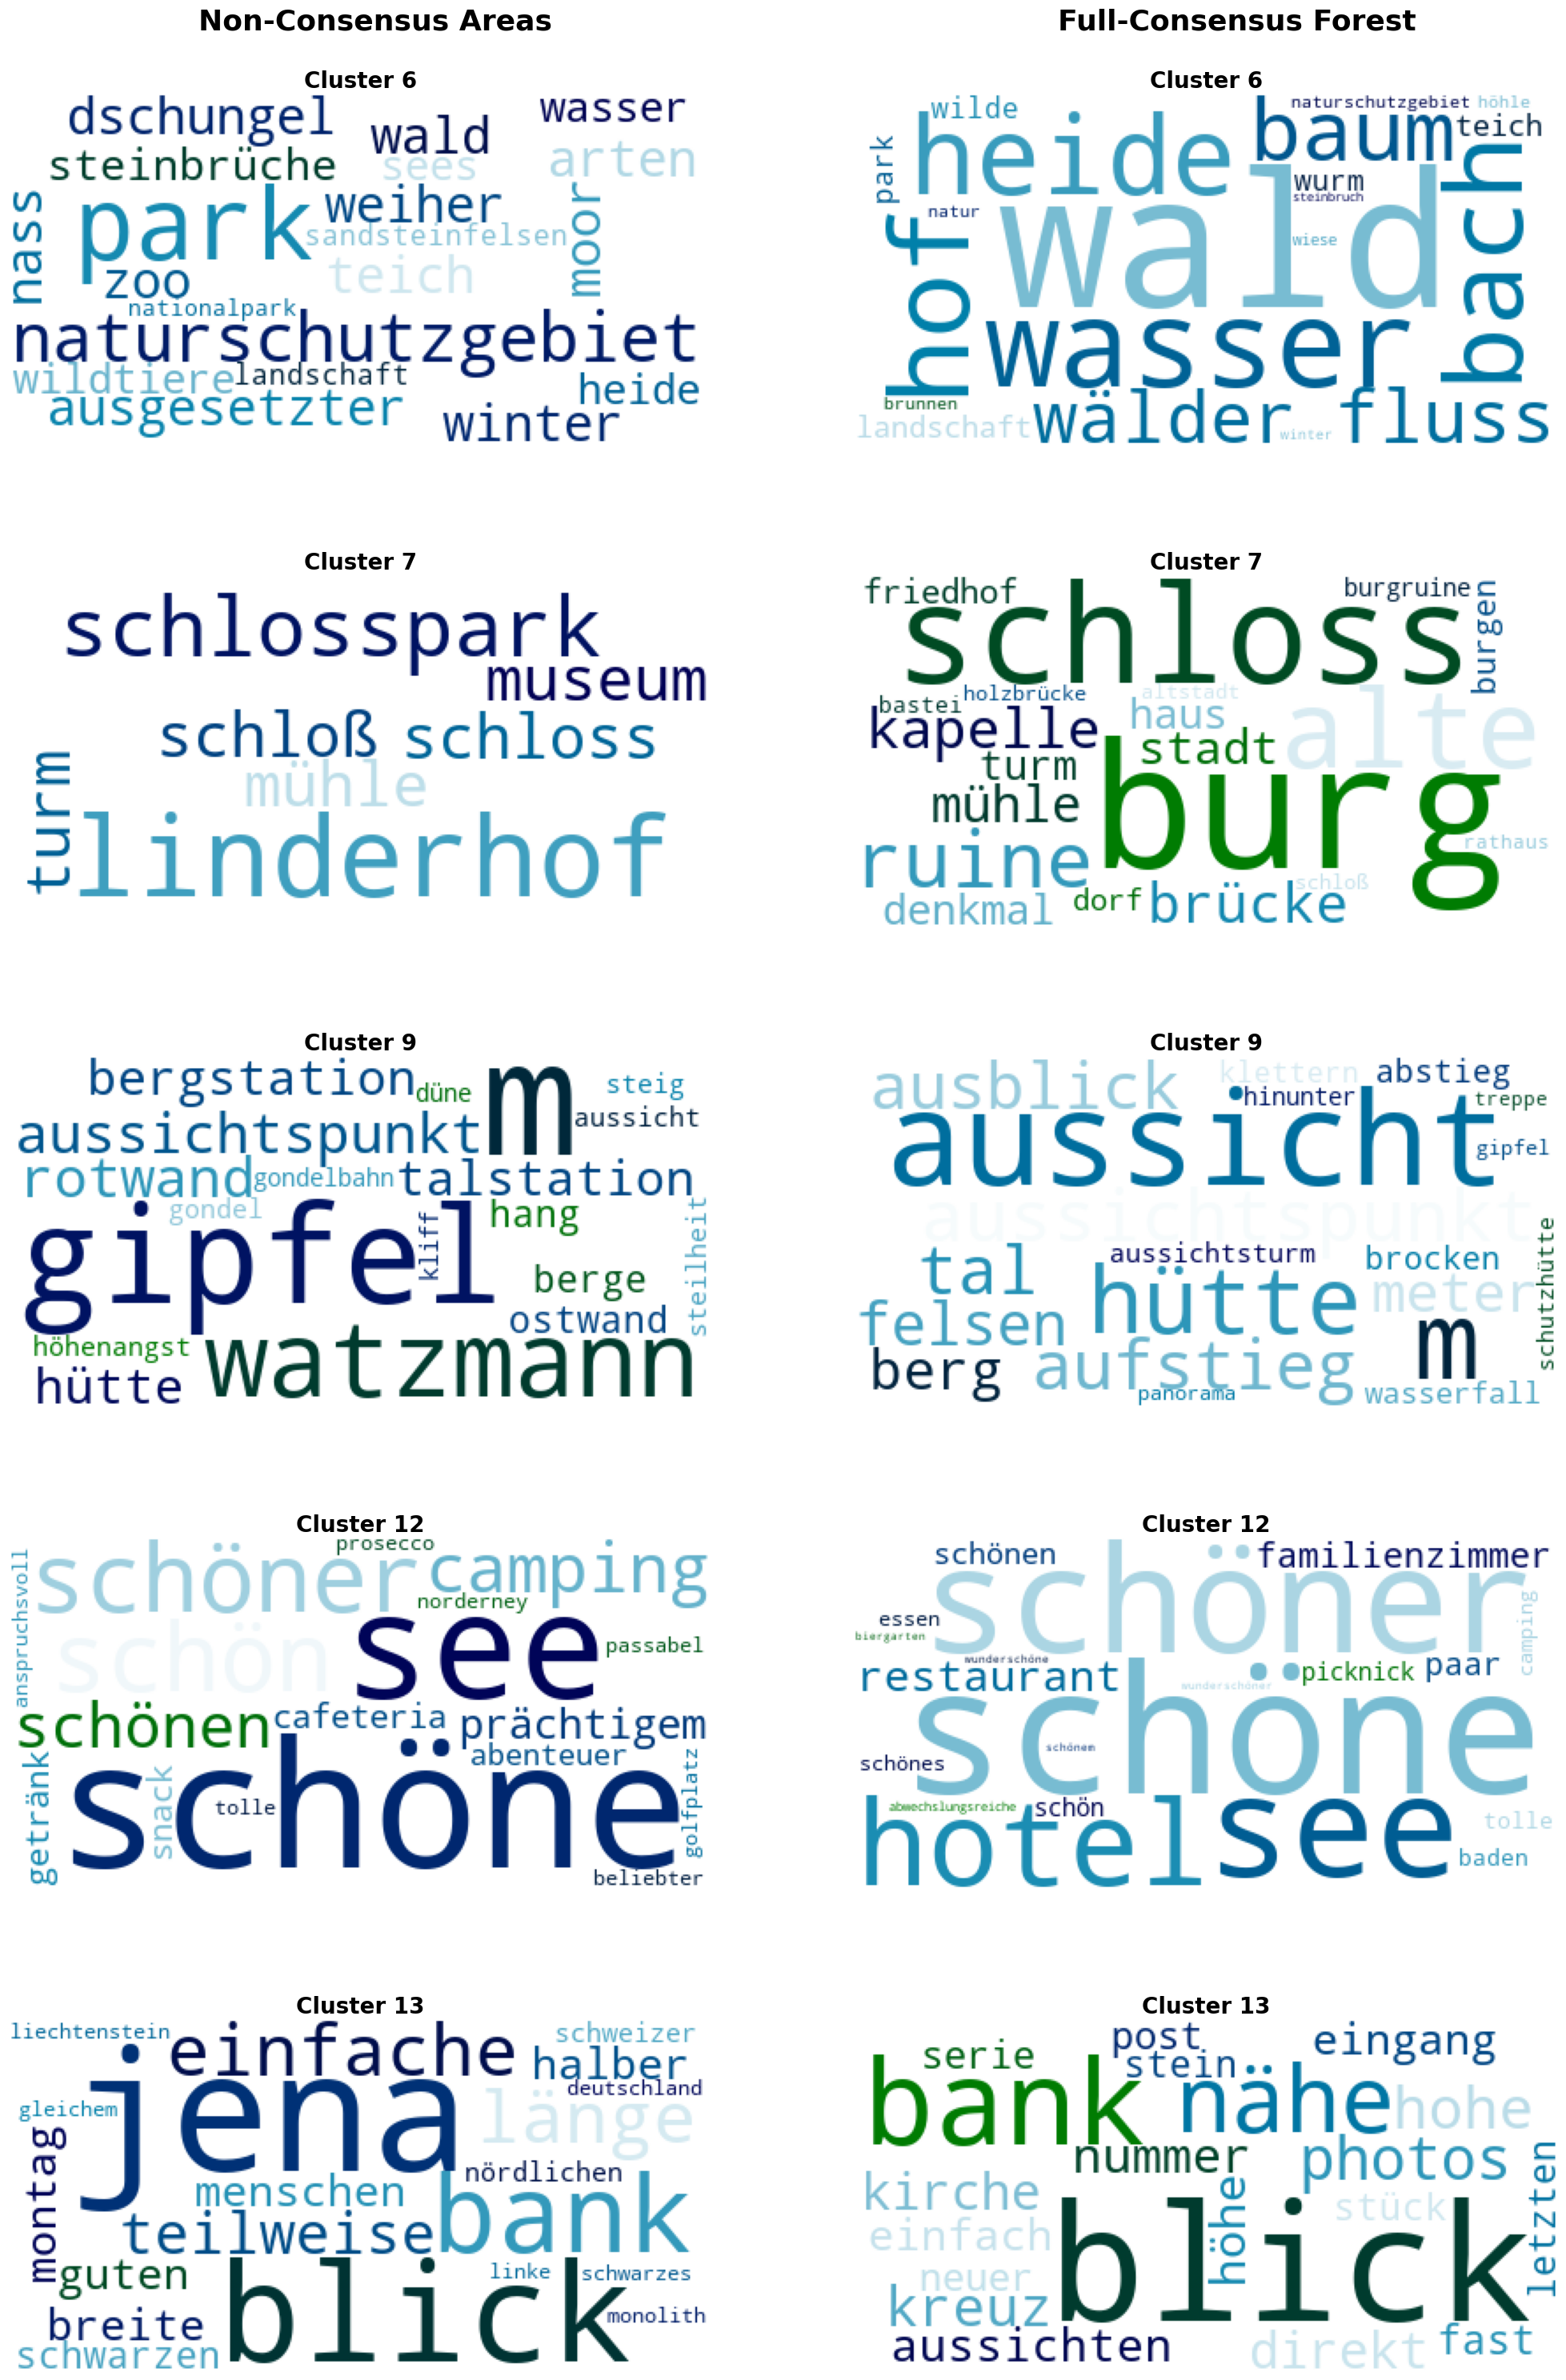

In [36]:
# STEP 3: WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc_c3 = []
all_wc_c6 = []

# For each cluster number use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 20 TOKENS IN EACH CLUSTER
for clus_num in [6,7,9,12,13]:  
    freqs = get_cluster_freq(filtered_clusters_c3, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='ocean', 
                   max_words=20).generate_from_frequencies(freqs)
    all_wc_c3.append(wc)

for clus_num in [6,7,9,12,13]:  
    freqs = get_cluster_freq(filtered_clusters_c6, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='ocean', 
                   max_words=20).generate_from_frequencies(freqs)
    all_wc_c6.append(wc)

# Create custom titles (shared for both c3 and c6)
all_titles = ["Cluster 6", "Cluster 7", "Cluster 9",
              "Cluster 12", "Cluster 13"]

# Create a single figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25, 35))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
for i in range(5):
    # Class 3 word clouds
    axes[i, 0].imshow(all_wc_c3[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(all_titles[i], fontsize=20, fontweight="bold")

    # Class 6 word clouds
    axes[i, 1].imshow(all_wc_c6[i])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(all_titles[i], fontsize=20, fontweight="bold")


# Adjust white space at the top to fit in main titles nicely
plt.subplots_adjust(top=0.93, wspace=0.2, hspace=0.3)

# Add column titles (first two numbers control the position)
fig.text(0.22, 0.95, "Non-Consensus Areas", fontsize=26, fontweight='bold')
fig.text(0.65, 0.95, "Full-Consensus Forest", fontsize=26, fontweight='bold')

plt.show()